In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
dataset = pd.read_csv(r'C:\Users\UMANG\Downloads\Py_DS_ML_Bootcamp-master\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\TensorFlow_FILES\TensorFlow_FILES\Notebooks\Tweets.csv')

In [3]:
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
dataset['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [5]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,569763359278505984,neutral,1.0000,NaN,NaN,United,NaN,manuel261984,NaN,0,@united whats UA 1205 lax - newark ??,NaN,2015-02-22 23:39:05 -0800,NaN,Mexico City
1,568918313239064576,negative,1.0000,Customer Service Issue,1.0000,Southwest,NaN,davidgoodson71,NaN,2,@SouthwestAir @JulGood1 she was traveling with...,NaN,2015-02-20 15:41:10 -0800,NaN,NaN
2,568851381769134080,positive,0.6639,NaN,NaN,Delta,NaN,JPopsie,NaN,0,@JetBlue I'll see you on board again soon!,NaN,2015-02-20 11:15:12 -0800,Global,Eastern Time (US & Canada)
3,569880788612866048,negative,1.0000,Late Flight,1.0000,Southwest,NaN,ucsigmachi,NaN,0,@SouthwestAir flight 1028 no delayed 1.5 hours...,NaN,2015-02-23 07:25:42 -0800,NaN,NaN
4,569077393886810112,negative,1.0000,Flight Attendant Complaints,0.3404,United,NaN,DaRenton,NaN,0,@united typically once you get the problem fix...,NaN,2015-02-21 02:13:18 -0800,Colorado,Mountain Time (US & Canada)


In [6]:
dataset.shape

(14640, 15)

In [7]:
#airline_sentiment coloumn to be pedicted --> To be predicted
#We'll also require the text column in order to get to know what the specific customer tweeted about the airline --> Input of neural network

In [8]:
dataset = dataset[['airline_sentiment', 'text']]
dataset

,airline_sentiment,text
0,neutral,@united whats UA 1205 lax - newark ??
1,negative,@SouthwestAir @JulGood1 she was traveling with...
2,positive,@JetBlue I'll see you on board again soon!
3,negative,@SouthwestAir flight 1028 no delayed 1.5 hours...
4,negative,@united typically once you get the problem fix...
...,...,...
14635,negative,@AmericanAir Fuck you.
14636,negative,@USAirways we've now learned to never fly with...
14637,negative,"@united yep that's correct, I got an email at ..."
14638,neutral,@AmericanAir I know. Just a little cold weathe...


In [9]:
%matplotlib inline

In [10]:
dataset['text'].str.len()

0         37
1         87
2         42
3         84
4        121
        ... 
14635     22
14636    132
14637    146
14638     57
14639    133
Name: text, Length: 14640, dtype: int64

<AxesSubplot:ylabel='Frequency'>

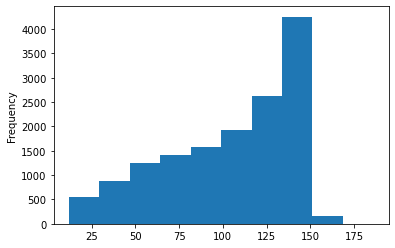

In [11]:
dataset['text'].str.len().plot.hist()

In [12]:
dataset['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

<AxesSubplot:>

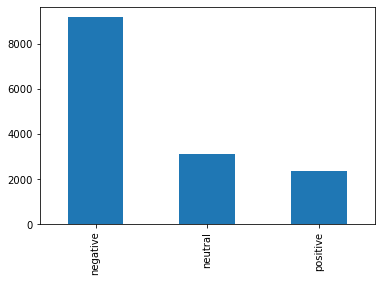

In [13]:
dataset['airline_sentiment'].value_counts().plot.bar()

In [14]:
#Getting rid of symbols which are not useful, and converting the uppercase letters to lowercase

In [15]:
dataset['text'] = dataset['text'].apply(lambda x: x.lower())
dataset['text']

0                    @united whats ua 1205 lax - newark ??
1        @southwestair @julgood1 she was traveling with...
2               @jetblue i'll see you on board again soon!
3        @southwestair flight 1028 no delayed 1.5 hours...
4        @united typically once you get the problem fix...
                               ...                        
14635                               @americanair fuck you.
14636    @usairways we've now learned to never fly with...
14637    @united yep that's correct, i got an email at ...
14638    @americanair i know. just a little cold weathe...
14639    @usairways and @flyknoxville - bad weather sho...
Name: text, Length: 14640, dtype: object

In [16]:
#Getting rid of the symbols with the help of Regular Expressions(Regex)

In [17]:
dataset['text'] = dataset['text'].apply(lambda text : re.sub('[^a-zA-Z0-9\s]',"",text))
dataset['text']

0                        united whats ua 1205 lax  newark 
1        southwestair julgood1 she was traveling with m...
2                  jetblue ill see you on board again soon
3        southwestair flight 1028 no delayed 15 hours  ...
4        united typically once you get the problem fixe...
                               ...                        
14635                                 americanair fuck you
14636    usairways weve now learned to never fly with u...
14637    united yep thats correct i got an email at 123...
14638    americanair i know just a little cold weather ...
14639    usairways and flyknoxville  bad weather should...
Name: text, Length: 14640, dtype: object

In [18]:
#Converting the text to numbers so that the neural networks can deal with it --> Tokenizer will help with this

In [19]:
dataset['text'].values

array(['united whats ua 1205 lax  newark ',
       'southwestair julgood1 she was traveling with me the one that got miscommunicated with',
       'jetblue ill see you on board again soon', ...,
       'united yep thats correct i got an email at 1230 am that the flight was cancelled flightled doesnt matter now flight into atl is delayed thx',
       'americanair i know just a little cold weather humor ',
       'usairways and flyknoxville  bad weather should not be an excuse for not following established luggage procedures noclothesnoinfo'],
      dtype=object)

In [20]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(dataset['text'].values)

In [21]:
#Converting the words to numbers using the text-to-sequence method, and
#Using pad_sequences to make the tweets of same length

In [22]:
X = tokenizer.texts_to_sequences(dataset['text'].values)
X = pad_sequences(X)

In [23]:
X[:6]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    5,  240,  528,  297,  529],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          16,  185,   23,  526,   25,   19,    2,   74,   26,   92,   25],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   17,  218,  152,    6,    9,  312,  103,  501],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          16,    8,   28,   77,  357,   56,  143,  301,  143,   77,    8],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    5, 4598,  4

In [24]:
#All the arrays are of same length since they are now padded with zeroes

In [25]:
X.shape

(14640, 33)

In [26]:
model = Sequential()

model.add(Embedding(5000, 256, input_length = X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout = 0.3, recurrent_dropout = 0.2))
model.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.2))
model.add(Dense(3, activation = 'softmax'))

In [27]:
#Softmax function is used since it is a classification problem

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 256)           1280000   
_________________________________________________________________
dropout (Dropout)            (None, 33, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 33, 256)           525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [29]:
y = pd.get_dummies(dataset['airline_sentiment']).values

In [30]:
[print(dataset['airline_sentiment'][i], y[i]) for i in range(0,7)]

neutral [0 1 0]
negative [1 0 0]
positive [0 0 1]
negative [1 0 0]
negative [1 0 0]
positive [0 0 1]
negative [1 0 0]


[None, None, None, None, None, None, None]

In [31]:
#The text are converted into numbers

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
model.fit(x=X_train, y=y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
366/366 - 156s - loss: 0.6439 - accuracy: 0.7371
Epoch 2/10
366/366 - 151s - loss: 0.4338 - accuracy: 0.8350
Epoch 3/10
366/366 - 153s - loss: 0.3491 - accuracy: 0.8663
Epoch 4/10
366/366 - 154s - loss: 0.2795 - accuracy: 0.8957
Epoch 5/10
366/366 - 181s - loss: 0.2369 - accuracy: 0.9114
Epoch 6/10
366/366 - 162s - loss: 0.1890 - accuracy: 0.9301
Epoch 7/10
366/366 - 162s - loss: 0.1575 - accuracy: 0.9419
Epoch 8/10
366/366 - 177s - loss: 0.1391 - accuracy: 0.9480
Epoch 9/10
366/366 - 164s - loss: 0.1249 - accuracy: 0.9529
Epoch 10/10
366/366 - 165s - loss: 0.1046 - accuracy: 0.9623


In [34]:
model.save(r'C:\Users\UMANG\Downloads\Py_DS_ML_Bootcamp-master\Refactored_Py_DS_ML_Bootcamp-master\22-Deep Learning\TensorFlow_FILES\TensorFlow_FILES\Notebooks\Sentiment_analysis.h5')

In [35]:
prediction = model.predict(X_test)

[print(dataset['text'][i], prediction[i], y_test[i]) for i in range(0,7)]

united whats ua 1205 lax  newark  [0.98894763 0.00915293 0.0018995 ] [0 0 1]
southwestair julgood1 she was traveling with me the one that got miscommunicated with [9.9909794e-01 8.3228108e-04 6.9761307e-05] [1 0 0]
jetblue ill see you on board again soon [0.292751   0.6637361  0.04351298] [0 1 0]
southwestair flight 1028 no delayed 15 hours  another week another delayed flight [2.4835719e-04 2.4017249e-03 9.9734986e-01] [0 0 1]
united typically once you get the problem fixed  then the crew expires  and the delay turns into a cancelled flight [0.917762   0.07546761 0.00677034] [1 0 0]
united he is so excellent and so reliable  happycustomer [9.9825627e-01 1.4196059e-03 3.2411987e-04] [1 0 0]
united no still trying to get home [0.0150802  0.97236866 0.01255103] [0 0 1]


[None, None, None, None, None, None, None]